In [ ]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(patchwork)
library(stringr)
library(ggplot2)

In [3]:
## https://drive.google.com/file/d/16Jq6w_KAWwI2rBN7SYBw-7bm5qwVoFyt/view?usp=drive_link
seu_obj <- readRDS(file="/project/zhuzhuzhang/lyang/scaleBio_RNA_rat_brain/out_mRatBN/merged_seurat_obj_celltype_annotated_2.rds")

In [5]:
## https://drive.google.com/file/d/1sWhyhm5V5RlxMEJhZ1BUncDxaI2_tGXJ/view?usp=drive_link
pseudo_de_sex <- readRDS(file = "./pseudo_sex_DESeq2_DEG_2.rds")

## plot for the DEG number in each cell type

In [138]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300)
p1 <- seu_obj@meta.data %>%
    #count(celltype) %>%
    mutate(group=factor(group,levels=c("soc","iso"))) %>%
    filter(celltype!="NA") %>%
    ggplot(aes(x=celltype))+
    geom_bar(fill="darkgrey")+
    geom_text(stat='count', aes(label=..count..), vjust=-0.2,size=2)+
    #geom_text(aes(label = n), vjust = 0.5,size=2)+
    facet_grid(sex~group)+
    labs(x="",y="# of cells")+
    theme_minimal()+
    theme(axis.text.x=element_blank(),
        #axis.text.x=element_text(angle=90,hjust=1),
         plot.margin = unit(c(0,0,0,0), "cm"))

In [131]:
options(repr.plot.width = 8, repr.plot.height = 2, repr.plot.res = 300)
p2 <- sapply(pseudo_de_sex,nrow) %>%
as.data.frame() %>%
setNames("gene_num") %>%
mutate(name=row.names(.)) %>%
mutate(celltype=str_split(name,"_",simplify = T)[,1],
      group=str_split(name,"_",simplify = T)[,2]) %>%
mutate(celltype=factor(celltype,levels=levels(seu_obj@meta.data$celltype)[1:15])) %>%
mutate(group=factor(group,levels=c("soc","iso"))) %>%
ggplot(aes(x=celltype,y=gene_num))+
    geom_bar(stat = "identity",fill="darkgrey")+
    geom_text(aes(label = gene_num),
              position = position_stack(vjust = 1.02),size=2)+
    facet_grid(.~group)+
    theme_minimal()+
    theme(axis.text.x = element_text(size=8,angle=30,hjust=1,vjust=1))+
    labs(y="gene number")

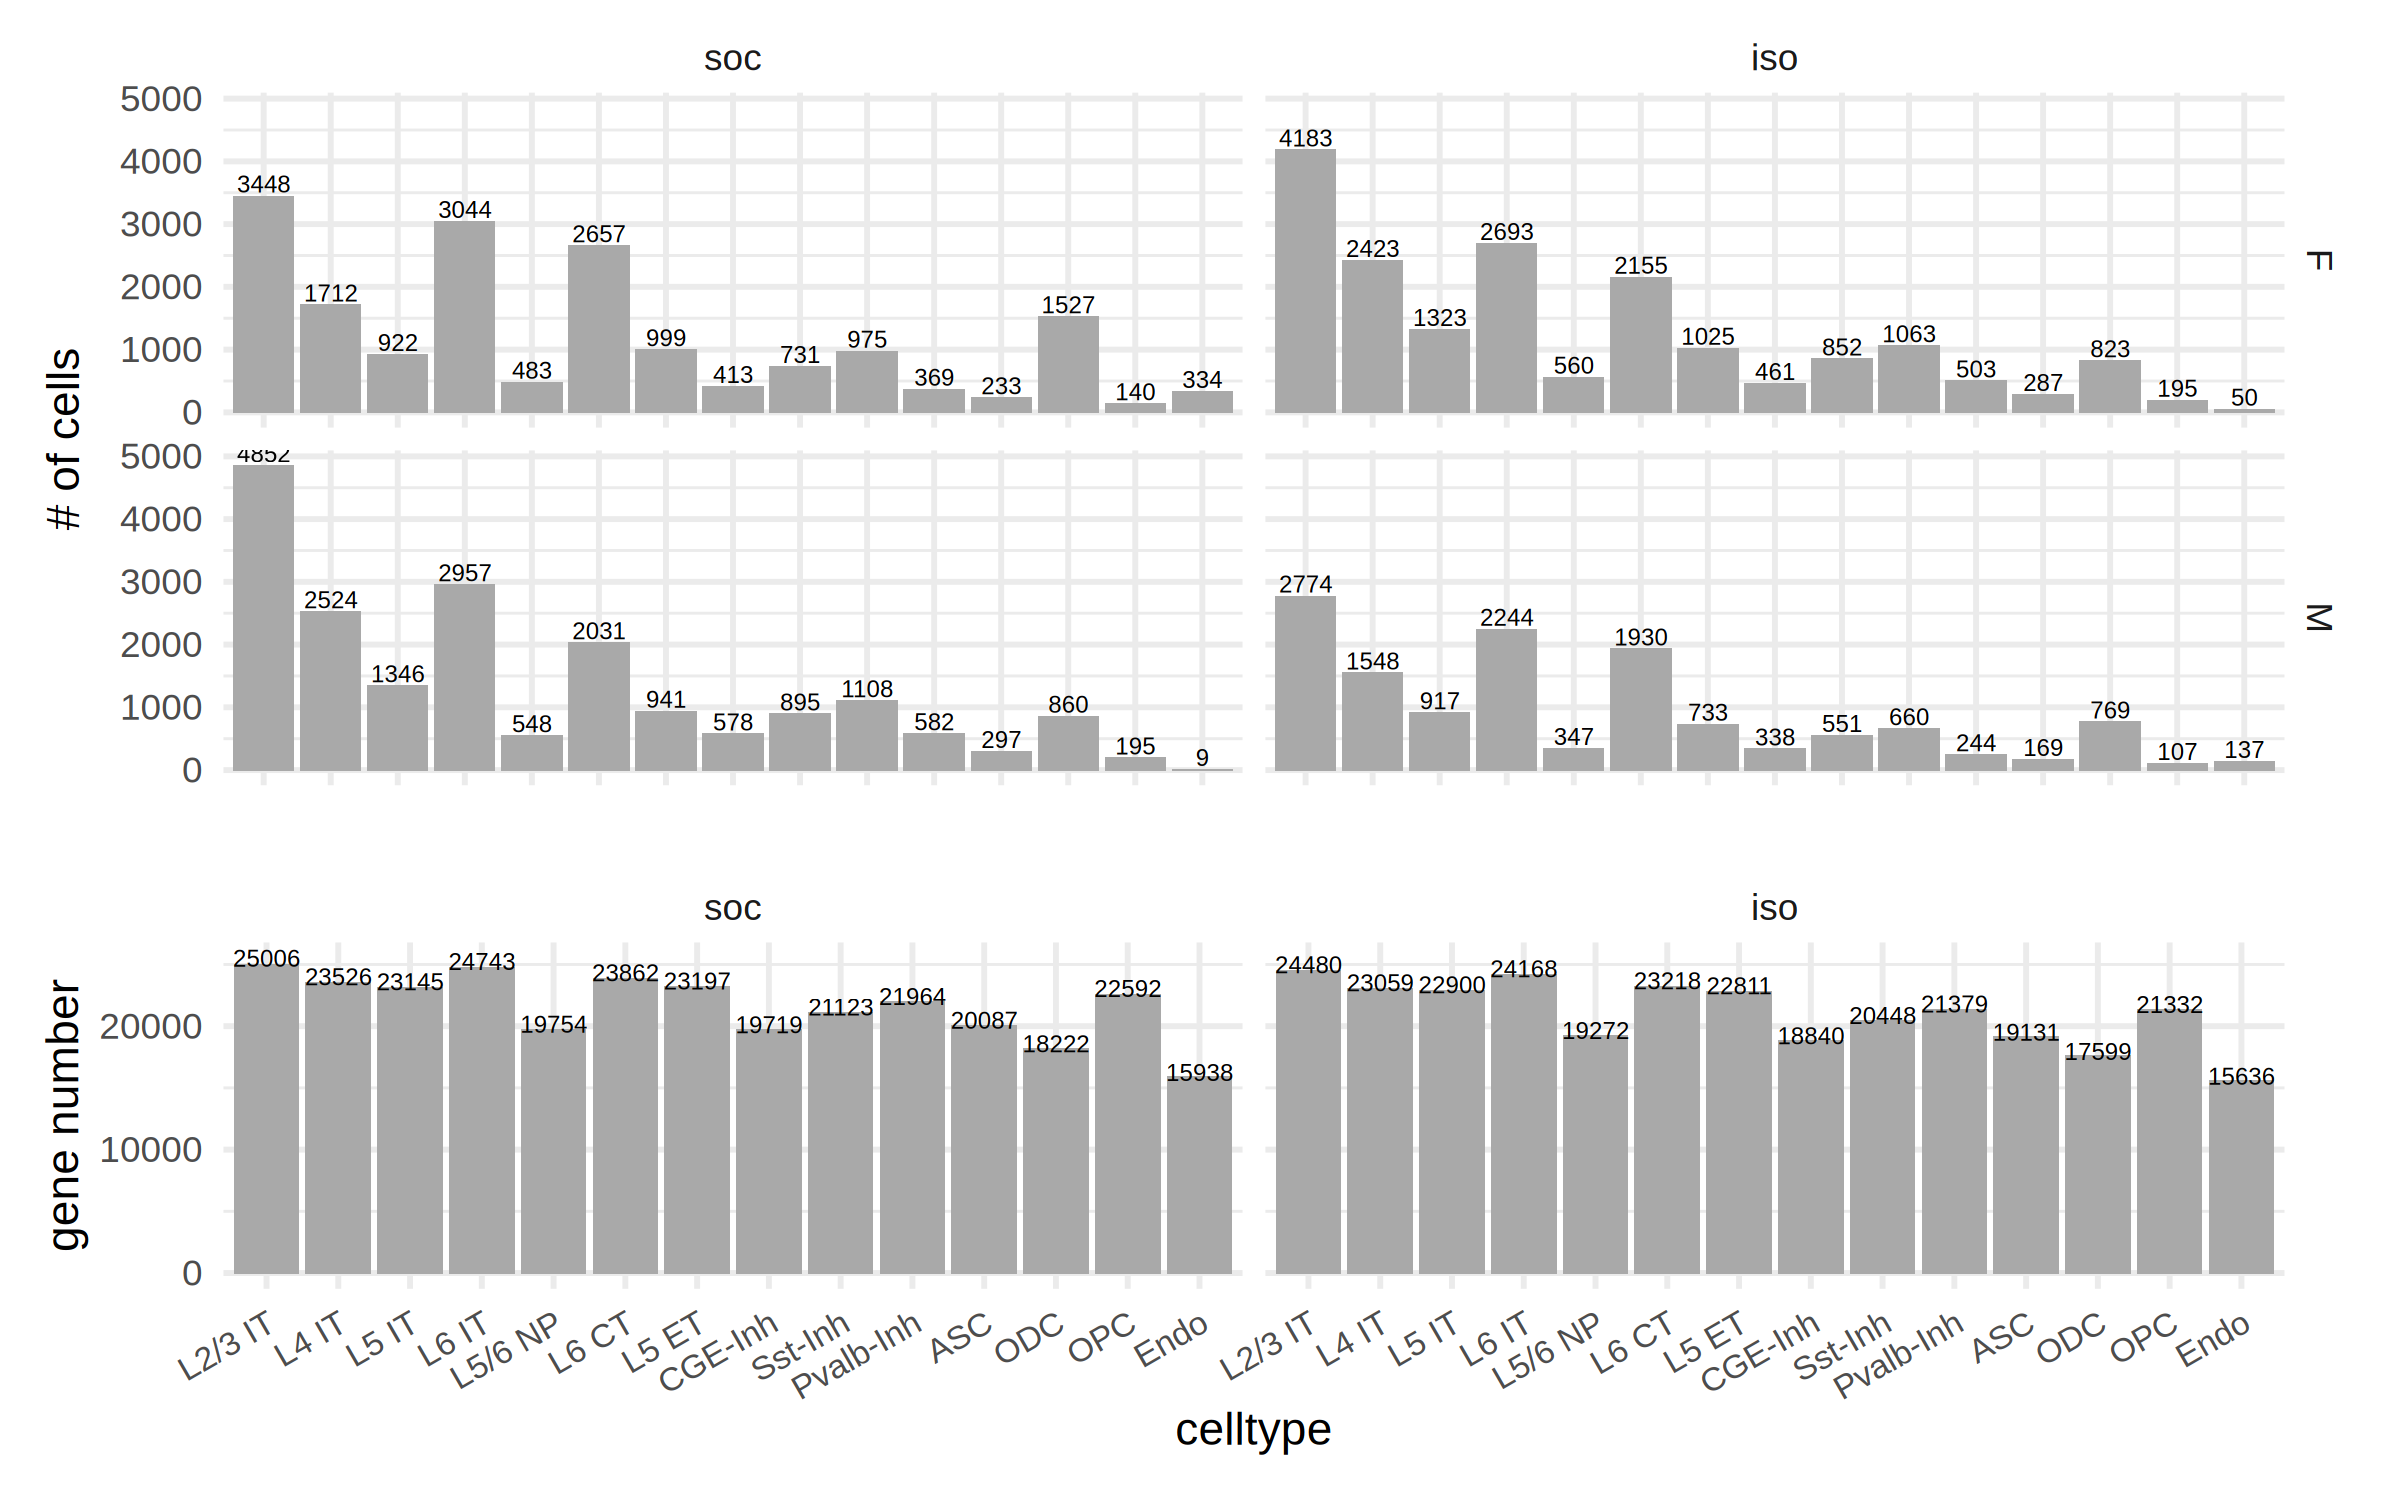

In [140]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)
p1/p2 + plot_layout(heights = c(2, 1))

## violin plots for genes

In [33]:
make_vlnplot <- 
function(seuObject,genes=NULL,celltype=NULL,label_df=NULL){
    VlnPlot(seuObject, 
        features = genes,
        idents=celltype,
        split.by = "sex",
        pt.size = 0.0,
        #split.plot = T,
        log=FALSE  )&
        scale_fill_manual(values=c("M"="#8ecae6","F"="#ffe5ec")) &
        annotate("text",x=label_df$celltype,y=Inf,label=label_df$P_label,vjust=1,hjust=0.5) &
        #stat_summary(fun = median, fun.min = median, fun.max = median,
        #         geom = "crossbar", 
        #         width = 0.6,
        #         position = position_dodge(width = .70)) &
                xlab("") &
                ylab("Gene Expression") &
          stat_summary(fun = "mean",
               geom = "point",
               color = "black",
               position = position_dodge(width = .90)) &
    labs(caption = paste("adj.p: ","**** <0.0001","*** <0.001","** <0.01","* <0.05")) &
    guides(fill = guide_legend(override.aes = list(linetype = 0,size = 0)),
               color = guide_legend(override.aes = list(linetype = 0,size=0)))
}

In [6]:
Idents(seu_obj) <- "celltype"
seu_obj@meta.data$group <- factor(seu_obj@meta.data$group,levels=c("soc","iso"))
seu_obj@meta.data$sex <- factor(seu_obj@meta.data$sex,levels=c("F","M"))

In [7]:
FvsM_DEG_ls <- read.table("FvsM_DEG_total_list.xls",sep="\t",stringsAsFactors = F,header=T)
FvsM_DEG_ls$P_label<- 
    symnum(FvsM_DEG_ls$p_val_adj, cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,1),
       symbols = c("****", "***", "**", "*", "ns"),
       abbr.colnames = FALSE, na = "")
FvsM_DEG_ls$celltype <- str_split(FvsM_DEG_ls$new_clumn,"_",simplify=T)[,1]
FvsM_DEG_ls$group <- str_split(FvsM_DEG_ls$new_clumn,"_",simplify=T)[,2]

In [16]:
table(FvsM_DEG_ls$group)


iso soc 
 82 211 

In [9]:
soc_gene_for_plot <- 
FvsM_DEG_ls %>%
    select(gene,new_clumn) %>%
    mutate(celltype=str_split(new_clumn,"_",simplify=T)[,1],
          group=str_split(new_clumn,"_",simplify=T)[,2]) %>%
    filter(group=="soc")%>%
    group_by(gene) %>%
    summarise(celltype = str_c(celltype, collapse=","))

iso_gene_for_plot <- 
FvsM_DEG_ls %>%
    select(gene,new_clumn) %>%
    mutate(celltype=str_split(new_clumn,"_",simplify=T)[,1],
          group=str_split(new_clumn,"_",simplify=T)[,2]) %>%
    filter(group=="iso")%>%
    group_by(gene) %>%
    summarise(celltype = str_c(celltype, collapse=","))

In [10]:
gene_ls <- c("Ndst4","Cdh12","Gpc5","Gpc6","Lingo2","Nrxn3","Ralyl")

In [ ]:
library(ggpubr)

In [ ]:
texto <- textGrob(
  label = c("adj.p","**** <0.0001","*** <0.001","** <0.01","* <0.05"),
  x = c(0,0,0,0,0),
  y = c(0,0.2,0.4,0.6,0.8),
  gp = gpar(lwd = 2, fontsize = 5),
  )

In [ ]:
iso_FvsM_DEGs <- unique(iso_gene_for_plot$gene)
pdf(file = "./Vlnplot_for_iso_FvsM_DEGs.pdf",width=8,height=4,onefile=TRUE)
seuObject <- subset(seu_obj,subset=group=="iso")
seuObject@meta.data$sex <- factor(seuObject@meta.data$sex,levels=c("M","F"))
for(i in seq_len(length(iso_FvsM_DEGs))){
    print(paste0("prcocessing gene: ",iso_FvsM_DEGs[i]))
    label_df <- 
        FvsM_DEG_ls %>%
        filter(gene==iso_FvsM_DEGs[i] & group=="iso")
    print(nrow(label_df))
    if(nrow(label_df)>0){
        p <- make_vlnplot(seuObject,
                      genes=iso_FvsM_DEGs[i],
                      celltype=levels(seu_obj@meta.data$celltype)[1:14],
                      label_df=label_df
                 )
        print(p)
    }
    
}
dev.off()

## save the data matrix for all DEGs between F and M

In [6]:
iso_compare <- pseudo_de_sex[names(pseudo_de_sex)[grep("iso",names(pseudo_de_sex))]]
soc_compare <- pseudo_de_sex[names(pseudo_de_sex)[grep("soc",names(pseudo_de_sex))]]

#### get the DEG list for iso group comparison

In [10]:
DEG_ls<-
lapply(seq_len(length(names(iso_compare))), function(x) {
    if (sum(iso_compare[[x]]$p_val_adj < 0.05 & abs(iso_compare[[x]]$avg_log2FC) > 0.3,na.rm = TRUE) > 0) {
        iso_compare[[x]] %>%
            filter(p_val_adj < 0.05, abs(avg_log2FC) > 0.3)
    }
})
names(DEG_ls) <- str_split(names(iso_compare),"_",simplify = T)[,1]
DEG_ls <- DEG_ls[!sapply(DEG_ls,is.null)]

## load gene coordinates information
gene_coord <- read.table("/project/zhuzhuzhang/lyang/references/mRatBN7.2_NCBI/gene_coordinates",header=F,stringsAsFactors = F) %>%
setNames(c("chr","start","end","strand","gene"))

do.call(rbind,Map(cbind, DEG_ls, new_clumn = names(DEG_ls))) %>%
  mutate(gene = str_split(row.names(.), "\\.", simplify = TRUE)[, 2]) %>%
    filter(gene != "") %>%
    left_join(gene_coord,by=c("gene"="gene")) %>%
    write.table("iso_FvsM_DEG_total_list.txt",sep="\t",quote=F,row.names=F)

#### get the DEG list for soc group comparison

In [15]:
DEG_ls<-
lapply(seq_len(length(names(soc_compare))), function(x) {
    if (sum(soc_compare[[x]]$p_val_adj < 0.05 & abs(soc_compare[[x]]$avg_log2FC) > 0.3,na.rm = TRUE) > 0) {
        soc_compare[[x]] %>%
            filter(p_val_adj < 0.05, abs(avg_log2FC) > 0.3)
    }
})
names(DEG_ls) <- str_split(names(soc_compare),"_",simplify = T)[,1]
DEG_ls <- DEG_ls[!sapply(DEG_ls,is.null)]

do.call(rbind,Map(cbind, DEG_ls, new_clumn = names(DEG_ls))) %>%
  mutate(gene = str_split(row.names(.), "\\.", simplify = TRUE)[, 2]) %>%
    filter(gene != "") %>%
    left_join(gene_coord,by=c("gene"="gene")) %>%
    write.table("soc_FvsM_DEG_total_list.txt",sep="\t",quote=F,row.names=F)

In [2]:
soc_FvsM_DEG <- read.table("soc_FvsM_DEG_total_list.txt",sep="\t",header=T)

In [3]:
iso_FvsM_DEG <- read.table("iso_FvsM_DEG_total_list.txt",sep="\t",header=T)

## save the FC data for all celltypes for all DEGs

### to make the asterisk labeled heatmap for F_vs_M DEGs

In [7]:
## gather fold change information together
DEG_ls<- 
lapply(seq_len(length(names(iso_compare))), function(x) {
        iso_compare[[x]] %>%
            filter(row.names(.) %in% unique(iso_FvsM_DEG$gene))
    })
names(DEG_ls) <- str_split(names(iso_compare),"_",simplify = T)[,1]
all_DEG_gene <- do.call(rbind,Map(cbind, DEG_ls, new_clumn = names(DEG_ls))) %>%
  mutate(gene = str_split(row.names(.), "\\.", simplify = TRUE)[, 2]) %>%
    filter(gene != "")

all_DEG_gene %>%
    select(new_clumn,avg_log2FC,gene) %>%
    tidyr::pivot_wider(names_from = new_clumn, values_from = avg_log2FC) %>%
    tibble::column_to_rownames(var="gene") %>%
    write.table(file="./iso_FvsM_DEG_FC_celltype_matrix.tsv",quote=F,sep="\t",row.names=T)

all_DEG_gene %>%
    select(new_clumn,p_val_adj,gene) %>%
    tidyr::pivot_wider(names_from = new_clumn, values_from = p_val_adj) %>%
    tibble::column_to_rownames(var="gene") %>%
    write.table(file="./iso_FvsM_DEG_adjP_celltype_matrix.tsv",quote=F,sep="\t",row.names=T)

same for social grouped comparison

In [20]:
## gather fold change information together
DEG_ls<- 
lapply(seq_len(length(names(soc_compare))), function(x) {
        soc_compare[[x]] %>%
            filter(row.names(.) %in% unique(soc_FvsM_DEG$gene))
    })
names(DEG_ls) <- str_split(names(soc_compare),"_",simplify = T)[,1]
all_DEG_gene <- do.call(rbind,Map(cbind, DEG_ls, new_clumn = names(DEG_ls))) %>%
  mutate(gene = str_split(row.names(.), "\\.", simplify = TRUE)[, 2]) %>%
    filter(gene != "")

all_DEG_gene %>%
    select(new_clumn,avg_log2FC,gene) %>%
    tidyr::pivot_wider(names_from = new_clumn, values_from = avg_log2FC) %>%
    tibble::column_to_rownames(var="gene") %>%
    write.table(file="./soc_FvsM_DEG_FC_celltype_matrix.tsv",quote=F,sep="\t",row.names=T)

all_DEG_gene %>%
    select(new_clumn,p_val_adj,gene) %>%
    tidyr::pivot_wider(names_from = new_clumn, values_from = p_val_adj) %>%
    tibble::column_to_rownames(var="gene") %>%
    write.table(file="./soc_FvsM_DEG_adjP_celltype_matrix.tsv",quote=F,sep="\t",row.names=T)

## make umaps for FvsM DEGs

In [99]:
iso_FvsM_DEG <- 
    FvsM_DEG_ls %>%
    filter(group=="iso") %>%
    pull(gene) %>%
    unique()
pdf(file = "./iso_FvsM_DEG_umap.pdf",width=10,height=5,onefile=TRUE)
for(i in seq_len(length(iso_FvsM_DEG))){
    p <- FeaturePlot(seu_obj, features = iso_FvsM_DEG[i],split.by="sex") + 
            theme(legend.position = c(-0.35,0.2))+
            theme(legend.text=element_text(size=10, color="black"))
    print(p)
}
dev.off()

png 
  2

In [108]:
soc_FvsM_DEG <- 
    FvsM_DEG_ls %>%
    filter(group=="soc") %>%
    pull(gene) %>%
    unique()

soc_FvsM_DEG <- 
    FvsM_DEG_ls %>%
    filter(group=="soc") %>%
    pull(gene) %>%
    unique()
pdf(file = "./soc_FvsM_DEG_umap.pdf",width=10,height=5,onefile=TRUE)
for(i in seq_len(length(soc_FvsM_DEG))){
    p <- FeaturePlot(seu_obj, features = soc_FvsM_DEG[i],split.by="sex") + 
            theme(legend.position = c(-0.35,0.2))+
            theme(legend.text=element_text(size=10, color="black"))
    print(p)
}
dev.off()

png 
  2

### make heatmap on the foldchanges of all DEGs between F vs. M in iso group

In [8]:
iso_FvsM_DEG_FC <- read.table("./iso_FvsM_DEG_FC_celltype_matrix.tsv", header=T,sep="\t",row.names=1)
iso_FvsM_DEG_P <- read.table("./iso_FvsM_DEG_adjP_celltype_matrix.tsv", header=T,sep="\t",row.names=1)

set cutoffs for asterisk label of significance

In [19]:
rm.neg<-plyr::colwise(function(x){
  return(ifelse(x < 0.0001,"****", 
                ifelse(x<0.001,"***",
                      ifelse(x<0.01,"**",
                            ifelse(x<0.05,"*","")))))})
p_sign_df <- rm.neg(iso_FvsM_DEG_P)

In [ ]:
## make sure the column names are consistent in the p-value and foldchange table
row.names(p_sign_df) <- row.names(iso_FvsM_DEG_P)
colnames(p_sign_df) <- c("L2/3 IT", "L4 IT", "L5 IT", "L6 IT", "L5/6 NP", "L6 CT", "L5 ET", "CGE-Inh", "Sst-Inh", "Pvalb-Inh", "ASC", "ODC", "OPC", "Endo")

colnames(iso_FvsM_DEG_FC) <- c("L2/3 IT", "L4 IT", "L5 IT", "L6 IT", "L5/6 NP", "L6 CT", "L5 ET", "CGE-Inh", "Sst-Inh", "Pvalb-Inh", "ASC", "ODC", "OPC", "Endo")

p_sign_df[is.na(p_sign_df)] <- ""
p_sign_df[abs(iso_FvsM_DEG_FC)<0.3] <- ""

In [ ]:
library(circlize)
library(ComplexHeatmap)

In [24]:
col_fun = colorRamp2(c(-5, 0, 5), c("#0077b6", "white", "#e63946"))
p = Heatmap(iso_FvsM_DEG_FC, name = "iso F/M\navg_logFC", col = col_fun,
        cluster_columns = F,
        show_row_dend = F,
        heatmap_legend_param = list(
            legend_direction = "horizontal", 
        legend_width = unit(6, "cm")),
        cell_fun = function(j, i, x, y, width, height, fill) {
            grid.text(sprintf("%s", p_sign_df[i, j]), x, y, gp = gpar(fontsize = 10))
})

lgd1 = Legend(labels=c("<0.0001","<0.001","<0.01","<0.05"),pch = c("**** ","*** ","** ","* "), title = "adj.p", type = "points", 
    background = "white",direction = "horizontal")
lgd2 = Legend(labels="gene not detected",legend_gp = gpar(fill = "grey"), title = "NA")

pdf("iso_FvsM_DEG_logFC_heatmap_2.pdf",width=7,height=8)
draw(p,annotation_legend_list = list(lgd1,lgd2),heatmap_legend_side="bottom", annotation_legend_side="right",
           legend_grouping = "original")
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


png 
  2

#### Same plot for soc group

In [26]:
soc_FvsM_DEG_FC <- read.table("./soc_FvsM_DEG_FC_celltype_matrix.tsv", header=T,sep="\t",row.names=1)
soc_FvsM_DEG_P <- read.table("./soc_FvsM_DEG_adjP_celltype_matrix.tsv", header=T,sep="\t",row.names=1)

p_sign_df <- rm.neg(soc_FvsM_DEG_P)
row.names(p_sign_df) <- row.names(soc_FvsM_DEG_P)
colnames(p_sign_df) <- c("L2/3 IT", "L4 IT", "L5 IT", "L6 IT", "L5/6 NP", "L6 CT", "L5 ET", "CGE-Inh", "Sst-Inh", "Pvalb-Inh", "ASC", "ODC", "OPC", "Endo")

colnames(soc_FvsM_DEG_FC) <- c("L2/3 IT", "L4 IT", "L5 IT", "L6 IT", "L5/6 NP", "L6 CT", "L5 ET", "CGE-Inh", "Sst-Inh", "Pvalb-Inh", "ASC", "ODC", "OPC", "Endo")
p_sign_df[is.na(p_sign_df)] <- ""
p_sign_df[abs(soc_FvsM_DEG_FC)<0.3] <- ""

In [27]:
col_fun = colorRamp2(c(-5, 0, 5), c("#0077b6", "white", "#e63946"))
p = Heatmap(soc_FvsM_DEG_FC, name = "soc F/M\navg_logFC", col = col_fun,
        cluster_columns = F,
        show_row_dend = F,
        heatmap_legend_param = list(
            legend_direction = "horizontal", 
        legend_width = unit(6, "cm")),
        row_names_gp = grid::gpar(fontsize = 4),
        cell_fun = function(j, i, x, y, width, height, fill) {
            gb = textGrob("*")
        	gb_w = convertWidth(grobWidth(gb), "mm")
        	gb_h = convertHeight(grobHeight(gb), "mm")
            grid.text(sprintf("%s", p_sign_df[i, j]), x, y - gb_h*0.5 + gb_w*0.4, gp = gpar(fontsize = 10))
})

lgd1 = Legend(labels=c("<0.0001","<0.001","<0.01","<0.05"),pch = c("**** ","*** ","** ","* "), title = "adj.p", type = "points", 
    background = "white",direction = "horizontal")
lgd2 = Legend(labels="gene not detected",legend_gp = gpar(fill = "grey"), title = "NA")

pdf("soc_FvsM_DEG_logFC_heatmap.pdf",width=6,height=12)
draw(p,annotation_legend_list = list(lgd1,lgd2),heatmap_legend_side="bottom", annotation_legend_side="right",
           legend_grouping = "original")
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


png 
  2